In [2]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import Doc2Vec
from gensim import utils
import gensim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import seaborn as sns
sns.set()
%matplotlib inline

In [12]:
class File2DocSpace(Doc2Vec):
    
    def __init__(self, file_name, epochs=1, size=80,
                 window=4,
                 min_count=2, workers=1,
                 alpha=0.5, min_alpha=0.025, batch_words=30,
                 train= True):
    
        self.file_name = file_name
        self.D, self.y = self.load_data()
        self.epochs = epochs
        self.dim = size
        # for scatter plot matrix functionality
        self.hues = pd.Series(self.y).map(lambda x: "blue" if x is 0 else "green")
        super(File2DocSpace, self).__init__(self.D, size=size,
                                            window=window,
                                            min_count=min_count, workers=workers,alpha=alpha,
                                            min_alpha=min_alpha, batch_words=batch_words)
        if train:
            self.train2()
            self.X = np.asarray(self.docvecs)
            self.docvecs = None # for RAM efficiency
        else:
            self.X = None

    def load_data(self):
        """
        Places data in list of labelled sentences format which
        allows gensim to build vocab automatically
        """
        with open(self.file_name) as f:
            lines = f.readlines()

        labels = list()
        all_dat = list()
        for i, l in enumerate(lines):

            labels.append(int(l[0]))

            l = gensim.utils.any2unicode(l)
            all_dat.append(LabeledSentence(l.split("\t")[-1], [i]))

        return all_dat, np.asarray(labels)
    
    def visualize_vec_as_mat(self):
        """
         Draws a set of samples from pargraph vector space
         and visualizes as a matrix
        
        """
        r1 = randint(self.dim, len(self.D) -1 )
        if self.X is not None:
            matrix = self.X[r1-self.dim:r1, :]
        else:
            matrix = np.asarray(self.docvecs)[r1-self.dim:r1, :]
        plt.matshow(matrix)
    
    
    def visualize_scatter_plot_mat(self, dim=6):
        dictio = {}
        r1 = randint(dim, (self.dim) )
        for i in range(r1-dim, r1):
            if self.X is not None:
                dictio["dimension "+ str(i)] = self.X[:,i]
            else:
                dictio["dimension "+ str(i)] = np.asarray(self.docvecs)[:,i]
        dictio["hue"] = self.hues
        df = pd.DataFrame(dictio)
        sns.pairplot(df, hue="hue")
    
    def train2(self):
        """
        Neural network SGD like trainign for paragraph vector estimation
        """
        for epoch in range(self.epochs):
            print "epoch: ", epoch
            self.train(self.D)
            self.alpha -= 0.002  # decrease the learning rate
            self.min_alpha = self.alpha  # fix the learning rate, no decay

In [13]:
model_word = File2DocSpace("training_data.txt", epochs=20, workers=4, size=20)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19


In [14]:
import cPickle as pkl

with open("word_model_20_20.pkl", "wb") as f:
    pkl.dump((model_word.X,model_word.y), f)


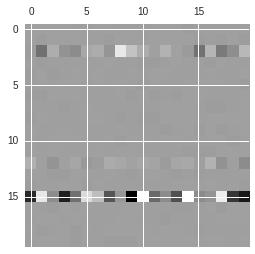

In [19]:
model_word.visualize_vec_as_mat()

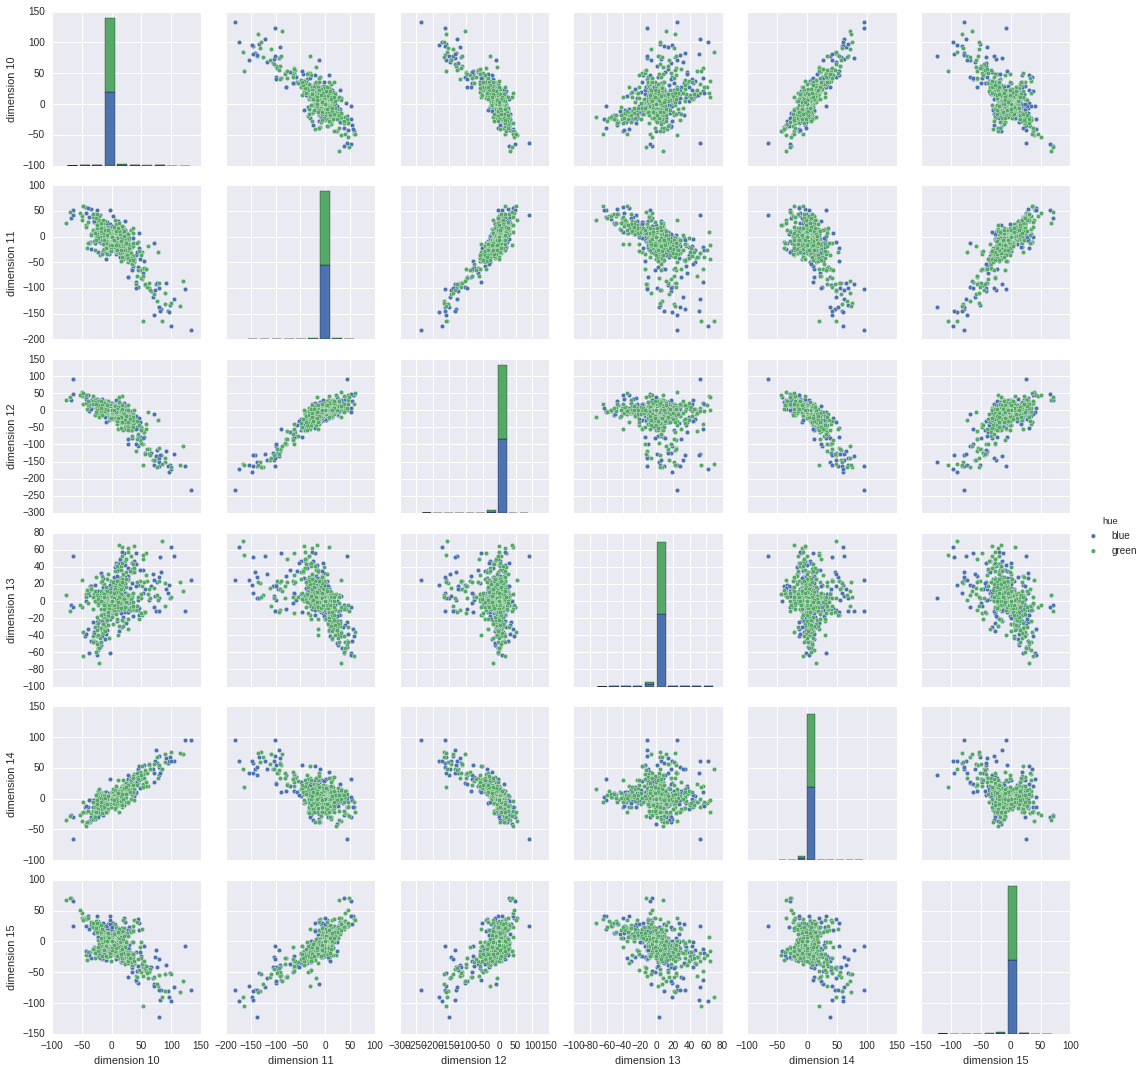

In [20]:
model_word.visualize_scatter_plot_mat()

In [ ]:
# model.X.shape
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

model = Sequential()
model.add(Dense(50, input_dim=20))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(model_word.X, model_word.y, test_size=0.33, random_state=42)
model.fit(X_train, to_categorical(y_train), 
          nb_epoch=500, batch_size=5000, validation_data=(X_test, to_categorical(y_test)))

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

def load_data(file_name="training_data.txt"):
    """
    Places data in list of labelled sentences format which
    allows gensim to build vocab automatically
    """
    with open(file_name) as f:
        lines = f.readlines()

    labels = list()
    all_dat = list()
    for i, l in enumerate(lines):

        labels.append(int(l[0]))

        l = gensim.utils.any2unicode(l)
        all_dat.append(l.split("\t")[-1])

    return all_dat, np.asarray(labels)

data, labels = load_data()

In [49]:
vect = TfidfVectorizer(min_df=0.001)
mat = vect.fit_transform(data).toarray()
print mat.shape

pca = PCA(n_components=2052)
mat2 = pca.fit_transform(mat)

(24544, 2052)


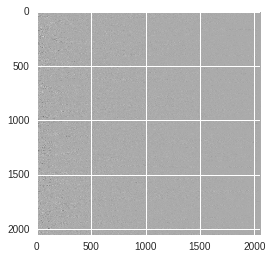

In [60]:
plt.imshow(mat2[0:2052,:])

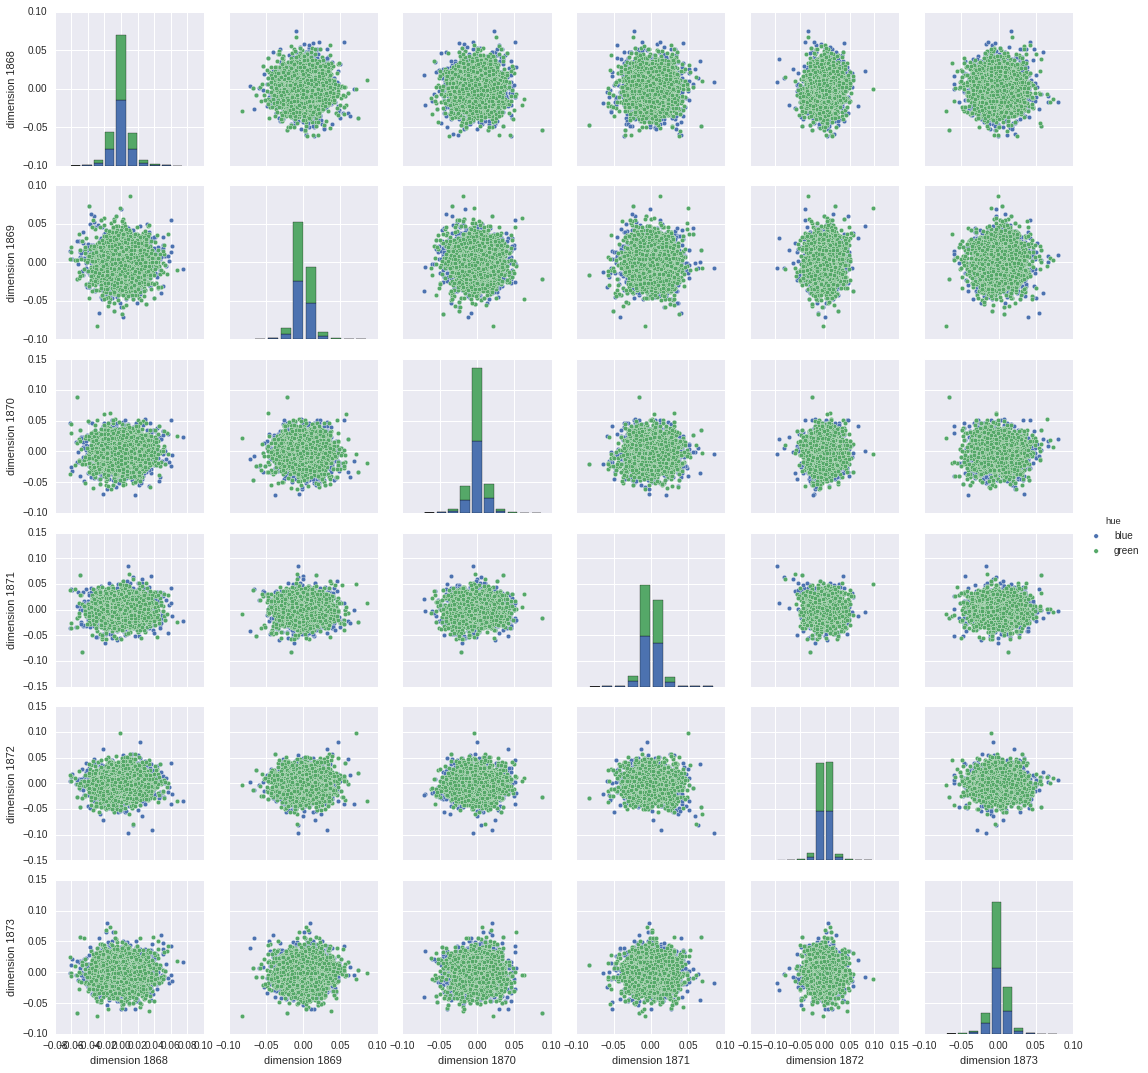

In [63]:
def visualize_scatter_plot_mat(dim=6):
    dictio = {}
    r1 = randint(dim, (2052) )
    for i in range(r1-dim, r1):
        dictio["dimension "+ str(i)] = mat2[:,i]
    dictio["hue"] = model_word.hues
    df = pd.DataFrame(dictio)
    sns.pairplot(df, hue="hue")
    
visualize_scatter_plot_mat()

In [78]:
# model.X.shape
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

model = Sequential()
model.add(Dense(50, input_dim=2052))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(mat2, model_word.y, test_size=0.2, random_state=42)
print y_test
y_test = ~ y_test.astype(bool)
y_test = y_test.astype(int)

model.fit(X_train, to_categorical(y_train), 
          nb_epoch=100, batch_size=500, validation_data=(X_test, to_categorical(y_test)))

[0 1 0 ..., 1 1 1]
Train on 19635 samples, validate on 4909 samples
Epoch 1/100
19635/19635 [==============================] - 1s - loss: 0.6936 - acc: 0.4884 - val_loss: 0.6927 - val_acc: 0.5284
Epoch 2/100
19635/19635 [==============================] - 0s - loss: 0.6908 - acc: 0.5505 - val_loss: 0.6923 - val_acc: 0.5356
Epoch 3/100
19635/19635 [==============================] - 0s - loss: 0.6840 - acc: 0.5723 - val_loss: 0.6926 - val_acc: 0.5437
Epoch 4/100
19635/19635 [==============================] - 0s - loss: 0.6728 - acc: 0.5895 - val_loss: 0.6943 - val_acc: 0.5543
Epoch 5/100
19635/19635 [==============================] - 0s - loss: 0.6609 - acc: 0.6065 - val_loss: 0.6971 - val_acc: 0.5639
Epoch 6/100
19635/19635 [==============================] - 0s - loss: 0.6508 - acc: 0.6168 - val_loss: 0.6964 - val_acc: 0.5746
Epoch 7/100
19635/19635 [==============================] - 0s - loss: 0.6419 - acc: 0.6273 - val_loss: 0.6970 - val_acc: 0.5798
Epoch 8/100
19635/19635 [===========